1. Construya una red de Kohonen de 2 entradas que aprenda una distribución uniforme
dentro del círculo unitario. Mostrar el mapa de preservación de topología. Probar con
distribuciones uniformes dentro de otras figuras geométricas.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
RNG = np.random.default_rng(2024)

In [41]:
# Funciones auxiliares para generar las figuras geométricas
def sample_unit_circle(n_samples, rng):
    angles = rng.uniform(0, 2 * np.pi, n_samples)
    radii = np.sqrt(rng.uniform(0, 1, n_samples))
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))


def sample_square(n_samples, rng, size=2.0):
    half = size / 2
    return rng.uniform(-half, half, size=(n_samples, 2))


def sample_parabola(n_samples, rng):
    x = rng.uniform(-1.0, 1.0, size=n_samples)
    y = 0.8 * (x ** 2) - 0.4 + rng.normal(0, 0.05, size=n_samples)
    y = np.clip(y, -1.0, 1.0)
    jitter_x = rng.normal(0, 0.03, size=n_samples)
    return np.column_stack((np.clip(x + jitter_x, -1.0, 1.0), y))


def sample_hyperbola(n_samples, rng, a=0.8, b=0.6):
    t = rng.uniform(0.2, 1.4, size=n_samples)
    signs_x = rng.choice([-1, 1], size=n_samples)
    signs_y = rng.choice([-1, 1], size=n_samples)
    x = signs_x * a * np.cosh(t)
    y = signs_y * b * np.sinh(t)
    data = np.column_stack((x, y))
    data /= np.max(np.abs(data))
    data += rng.normal(0, 0.02, size=data.shape)
    return np.clip(data, -1.0, 1.0)


In [ ]:
class Kohonen:
    def __init__(self, grid_shape=(12, 12), input_dim=2, learning_rate=0.5, radius=None, seed=0):
        self.grid_shape = grid_shape
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.rng = np.random.default_rng(seed)
        self.weights = self.rng.uniform(-1, 1, size=(*grid_shape, input_dim))
        self.initial_radius = radius if radius is not None else max(grid_shape) / 2
        self.initial_radius = max(self.initial_radius, 1.0)

    def _winner(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=2)
        winner_index = np.unravel_index(np.argmin(distances), self.grid_shape)
        return winner_index

    def _neighborhood(self, winner_index, radius):
        gx, gy = np.indices(self.grid_shape)
        dist_sq = (gx - winner_index[0]) ** 2 + (gy - winner_index[1]) ** 2
        return np.exp(-dist_sq / (2 * (radius ** 2)))

    def train(self, data, epochs=4000):
        time_constant = epochs / np.log(self.initial_radius)
        for epoch in range(epochs):
            sample = data[self.rng.integers(0, len(data))]
            lr = self.learning_rate * np.exp(-epoch / epochs)
            radius = self.initial_radius * np.exp(-epoch / time_constant)
            radius = max(radius, 1.0)
            winner = self._winner(sample)
            influence = self._neighborhood(winner, radius)[..., None]
            self.weights += influence * lr * (sample - self.weights)


In [36]:
def plot_som_results(data, som, title):
    weights = som.weights
    fig, ax = plt.subplots(figsize=(4.8, 4.8))

    line_color = '#1f77b4'
    for i in range(weights.shape[0]):
        ax.plot(weights[i, :, 0], weights[i, :, 1], color=line_color, linewidth=1.1)
    for j in range(weights.shape[1]):
        ax.plot(weights[:, j, 0], weights[:, j, 1], color=line_color, linewidth=1.1)

    ax.scatter(weights[..., 0].ravel(), weights[..., 1].ravel(), c=line_color, s=30)

    ax.set_aspect('equal', 'box')
    extent = np.max(np.abs(np.vstack((data, weights.reshape(-1, 2)))))
    limit = max(0.75, min(1.2, extent * 1.05))
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ticks = np.round(np.linspace(-limit, limit, 5), 2)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel('X'),
    ax.set_ylabel('m'),
    ax.set_title(title)
    for spine in ax.spines.values():
        spine.set_color('0.2')
    plt.tight_layout()


### Cuadrado


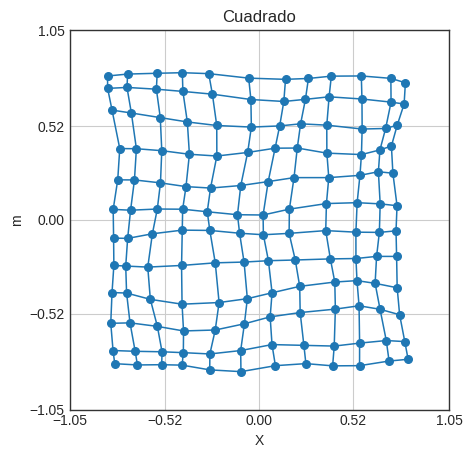

In [37]:
som_cuadrado = entrenar_figura("Cuadrado", sample_square)

### Círculo

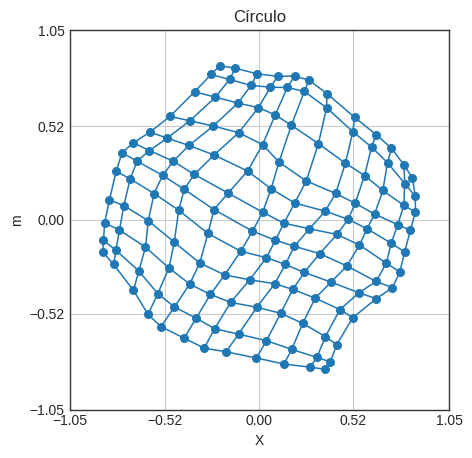

In [38]:
som_circulo = entrenar_figura("Círculo", sample_unit_circle)

### Parábola
Se usa la parábola $y = 0.8x^2 - 0.4$.
Tener en cuenta que se podría usar cualquier otra

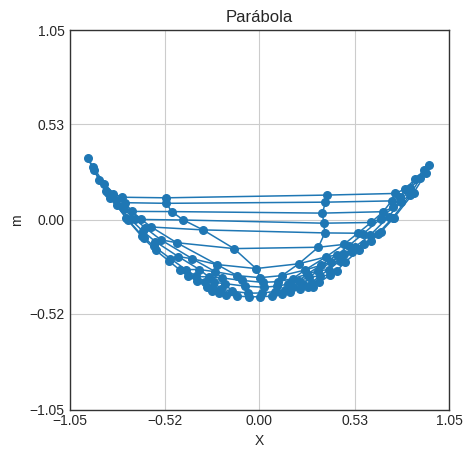

In [39]:
som_parabola = entrenar_figura("Parábola", sample_parabola)

### Hipérbola
Se usa la parametrización $x = a\cosh(t),\ y = b\sinh(t)$ 

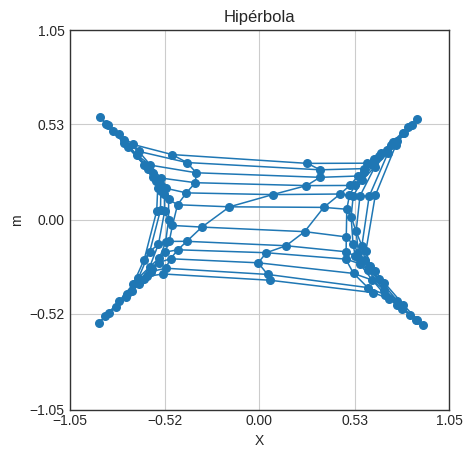

In [40]:
som_hiperbola = entrenar_figura("Hipérbola", sample_hyperbola)